# Задача

15 апреля 1912 года во время своего первого рейса «Титаник», считавшийся «непотопляемым», затонул после столкновения с айсбергом. К сожалению, спасательных шлюпок на всех на борту не хватило, в результате чего из 2224 пассажиров и членов экипажа погибли 1502 человека.

Хотя в выживании был некоторый элемент удачи, кажется, что у некоторых групп людей было больше шансов выжить, чем у других.

<b>В этом задании мы просим вас построить прогностическую модель, отвечающую на вопрос: «У каких людей больше шансов выжить?» используя данные о пассажирах (например, имя, возраст, пол, социально-экономический класс и т. д.).</b>

## Решим данную задачу с помощью метода Решающий пень (Decision Stump)

In [1]:
# Импортируем модули

import numpy as np                                          # Библиотека для работы с данными

import pandas as pd                                         # Библиотека для работы с таблицами

from sklearn.model_selection import train_test_split        # Метод для разделения данных на обучающую и проверочную выборки

In [2]:
# Загружаем данные

train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
train[(train['Sex']=='male') & (train['Embarked']=='S')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S


## Предобработка данных

In [8]:
# Удаляем ненужные факторы

useless_columns = ['Name', 'Ticket', 'Cabin']

train_clean = train.drop(columns=useless_columns)
test_clean = test.drop(columns=useless_columns)

In [18]:
# Заполнение пропущенных данных #NaN
def impute_data(df):
    df_copy=df # Копируем, чтобы не изменять оригинал
    
    # Заполняем пропущенные значения для категориальных переменных самым часто встречающимся значением в колонке
    categorial_vars = list(df_copy.select_dtypes(include=['object']).columns.values)
    for col in categorial_vars:
        
        if (df_copy[col].isnull().values.any()):
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
            
            
    # Заполняем пропущенные значения для количественных переменных медианой по столбцу
    numerical_vars = list(df_copy.select_dtypes(include=['int64', 'float64']).columns.values)
    for col in numerical_vars:
        
        if (df_copy[col].isnull().values.any()):
            df_copy[col].fillna(df_copy[col].median(), inplace=True)
            
    return df_copy

In [19]:
train_full = impute_data(train_clean)
test_full = impute_data(test_clean)

In [20]:
# Проверим данные после заполнения
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


## Визуализация данных

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

Мужчины умирают гораздо чаще

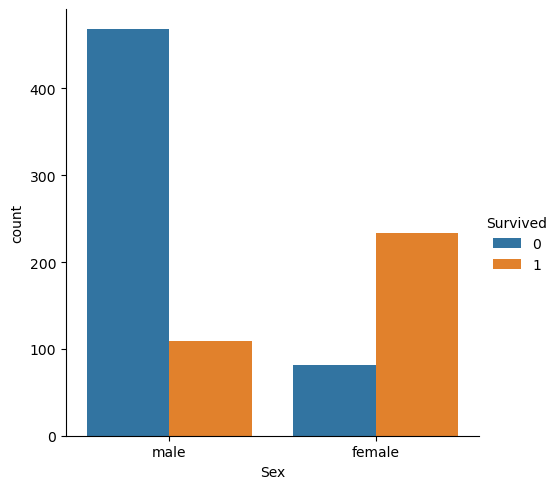

In [31]:
sns.catplot(x='Sex', data=train_full, hue='Survived', kind='count')

Богатые люди спаслись больше, чем бедные

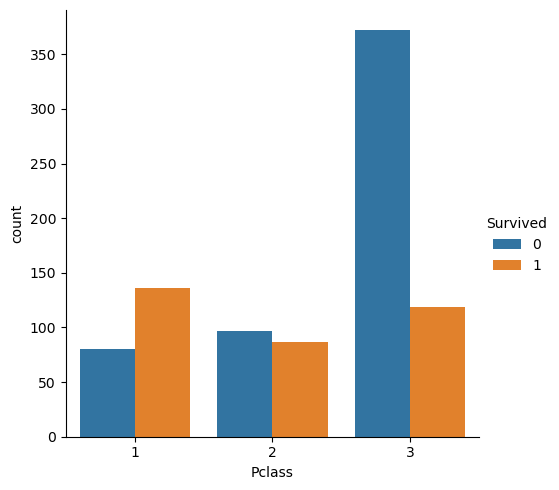

In [32]:
sns.catplot(x='Pclass', data=train_full, hue='Survived', kind='count')

При этом бедных было больше чем остальных

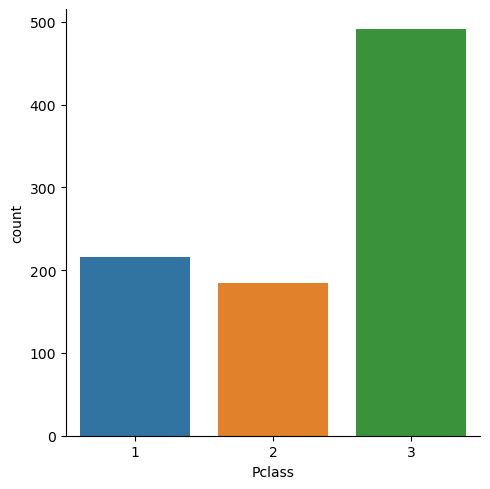

In [33]:
sns.catplot(x='Pclass', data=train_full, kind='count')

Бедных мужчин было больше всех

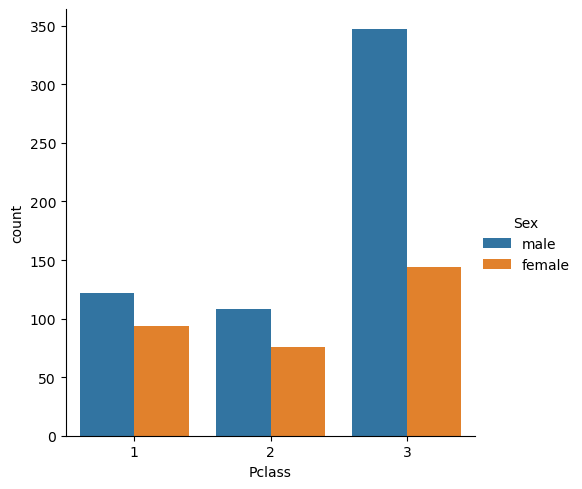

In [34]:
sns.catplot(x='Pclass', data=train_full, hue='Sex', kind='count')

# Метод Решающий пень (Decision stump)

In [37]:
(test_full['Sex'] == 'male') & (test_full['Pclass'] == 3)

0       True
1      False
2      False
3       True
4      False
       ...  
413     True
414    False
415     True
416     True
417     True
Length: 418, dtype: bool

In [38]:
# Выбираем всех мужчин, которые были в 3-ем (бедном) классе и говорим, что они не выжили
simple_pred = (~((test_full['Sex'] == 'male') & (test_full['Pclass'] == 3))).astype(int).values

In [39]:
# Функция для составления submission-файла соревнования

def make_prediction_file(prediction, test_data, name):
    
    result = pd.DataFrame({
        'PassengerId': test_data.reset_index()['PassengerId'],
        'Survived': prediction})
    result.to_csv(name, index=False)

In [41]:
make_prediction_file(simple_pred, test, 'titanic_simple_baseline.csv')

# Вывод: Точность данного метода составила 59%